Milestone 1, by Bram, Joep, Sybren and Matthijs

The aim of this notebook is to clean the data, get better insight in the problem and make a modelchoice.


Importing the data and modules used for the cleaning and preliminary model

In [1]:
# Imports
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Read in the train data
train_data = pd.read_csv('Data/train.csv')

# Read in the test data & prices and concat them
test_data  = pd.read_csv('Data/test.csv')
test_prices = pd.read_csv('Data/sample_submission.csv')
test_prices.drop(['Id'], axis = 1, inplace=True)
test_data = pd.concat([test_data, test_prices], axis=1)

# Merge the train and test, will be split later again.
data = pd.concat([train_data, test_data]).reset_index()

display(data)


,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.000000
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.000000
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.000000
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.000000
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,167081.220949
2915,1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,164788.778231
2916,1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,219222.423400
2917,1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,184924.279659


Cleaning the data:

- Check what features have NaN values
- If more than one thirds of the entries is missing the feature wil be deleted

In [2]:
def check_missing(dataframe):
    '''
    Function to check what categories have missing data.
    '''

    # Check how many NaN values occur in a category
    nan_data  = dataframe.isna().sum().sort_values(ascending=False)

    # Make a dictionary out of the missing categories where the occurance of NaN > 0
    missing_categories = dict(nan_data.mask(nan_data == 0).dropna())

    # Return the dictionary
    return missing_categories

In [3]:

def clean_data(data, throwaway):
    '''
    Function to clean the data, decisions are based on how many NaN's a category has.

    Input: dataframe data, float throwaway (above what percentage the feature should be thrown away)
    '''

    dataframe  = data.copy()

    

    missing_categories = check_missing(dataframe)
    
    # Drop the features with a lot of Nan data
    for feature in missing_categories:

        # The amount of NaN's in this category
        NaN_amount = missing_categories[feature]

        # If a category contains more NaN's than 1 third of the samples, remove the category
        if NaN_amount > (len(dataframe)/(1/throwaway*100)):
            dataframe.drop([feature], axis=1, inplace = True)

        # If it does not fall in the first condition, check if data is numerical or ordinal for the next step.
        elif is_string_dtype(dataframe[feature]):

            # For strings replace the NaN's with the mode value
            dataframe[feature].fillna(value=dataframe[feature].mode()[0], inplace=True)

        elif is_numeric_dtype(dataframe[feature]):

            # For numeric data replace the NaN's with the mean value
            dataframe[feature].fillna(value=dataframe[feature].mean(), inplace=True)


    # Check is all NaN  values have been filled

    assert len(check_missing(dataframe)) == 0, 'Still contains NaN'

    # Return the cleaned dataframe
    return dataframe
            


# Apply the function
data_cleaned = clean_data(data, (100/3))

# Display the cleaned data
display(data_cleaned)





    

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,208500.000000
1,1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,181500.000000
2,2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,223500.000000
3,3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,...,272,0,0,0,0,2,2006,WD,Abnorml,140000.000000
4,4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,6,2006,WD,Normal,167081.220949
2915,1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2006,WD,Abnorml,164788.778231
2916,1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,9,2006,WD,Abnorml,219222.423400
2917,1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,...,0,0,0,0,700,7,2006,WD,Normal,184924.279659


For both the linear regression and random forest we need to convert the categorical data. We do this by one hot encoding with the dummies function in pandas. Also the training data is splitted from the target labels withs the split_x_y function.

In [4]:
def one_hot_encoding(data):
    '''
    Function to convert data in dataframe to all numerical using onehot encoding.
    '''
    # Create a copy
    dataframe = data.copy()

    # Convert categorical data to numerical
    dataframe = pd.get_dummies(data=dataframe)

    # Return the new dataframe
    return dataframe



def label_encoding(data):
    '''
    Function to convert data in a dataframe to all numerical using label encoding
    '''

    # Create a copy
    dataframe = data.copy()

    # Go over all the features in the dataframe
    for feature in dataframe.columns:

        # If the data of the feature is categorical, apply label encoding for said column
        if is_string_dtype(dataframe[feature]):

            le = preprocessing.LabelEncoder()
            le.fit(dataframe[feature])
            dataframe[feature] = le.transform(dataframe[feature])

            # NOTE: Maybe make dictionary for saving the LabelEncoder classes, to convert the classes back to the original strings later.

    return dataframe


def split_x_y(data):
    '''
    Function to split data in x and y
    '''
    # Create a copy
    dataframe = data.copy()

    # Create y series
    y = dataframe['SalePrice']

    # Drop the y from the x features
    dataframe.drop(['SalePrice'], axis = 1, inplace=True)

    return dataframe, y



For the models we are considering using:

- Random Forest
- Linear Regression

Let's start with linear regression

In [9]:
# Converting the data to numerical, for now 2 methods are used.
data_num_ohe = one_hot_encoding(data_cleaned)
data_num_le = one_hot_encoding(data_cleaned)

# Create X and Y data
data_num_ohe_x, data_num_ohe_y = split_x_y(data_num_ohe)
data_num_le_x, data_num_le_y = split_x_y(data_num_le)

# Create test and train split
train_num_ohe_x, test_num_ohe_x, train_num_ohe_y, test_num_ohe_y = train_test_split(data_num_ohe_x, data_num_ohe_y, test_size = 0.3, random_state=40)
train_num_le_x, test_num_le_x, train_num_le_y, test_num_le_y = train_test_split(data_num_le_x, data_num_le_y, test_size = 0.3, random_state=40)


train_num_le_x = train_num_le_x.reset_index(drop=True)
train_num_le_y = train_num_le_y.reset_index(drop=True)
test_num_le_x = test_num_le_x.reset_index(drop=True)
test_num_le_y = test_num_le_y.reset_index(drop=True)



# Make a model
LinearModel = LinearRegression()
# Fit the data
LinearModel.fit(train_num_le_x, train_num_le_y)
# Predict train
train_prediction_reg = LinearModel.predict(train_num_le_x)
# Predict test
y_prediction_reg = LinearModel.predict(test_num_le_x)



Random Forest:

In [6]:
# Creating forests
regr = RandomForestRegressor(max_depth=5, random_state=3)
regr.fit(train_num_le_x, train_num_le_y)

# Getting prediction and calculating accuracy
y_prediction_forest = regr.predict(test_num_le_x)
train_prediction_forest = regr.predict(train_num_le_x)

Calculating the average deviation from the price.

In [13]:
# Calculate average deviation
def dev(y, y_hat):
    tot = 0
    for i in range(len(y)):
        tot += abs(y[i]-y_hat[i])
    return tot / len(y)

# Regression
print('Regression')
print('test', dev(test_num_le_y, y_prediction_reg))
print('train', dev(train_num_le_y, train_prediction_reg))
print('\n')


# Forest
print('Forest')
print('test', dev(test_num_le_y, y_prediction_forest))
print('train', dev(train_num_le_y, train_prediction_forest))

Regression
test 13713988.532029228
train 26497.828687027577


Forest
test 14026.339831767265
train 11715.76473207217


Visualizing the data to aid our model choice, see the paper.

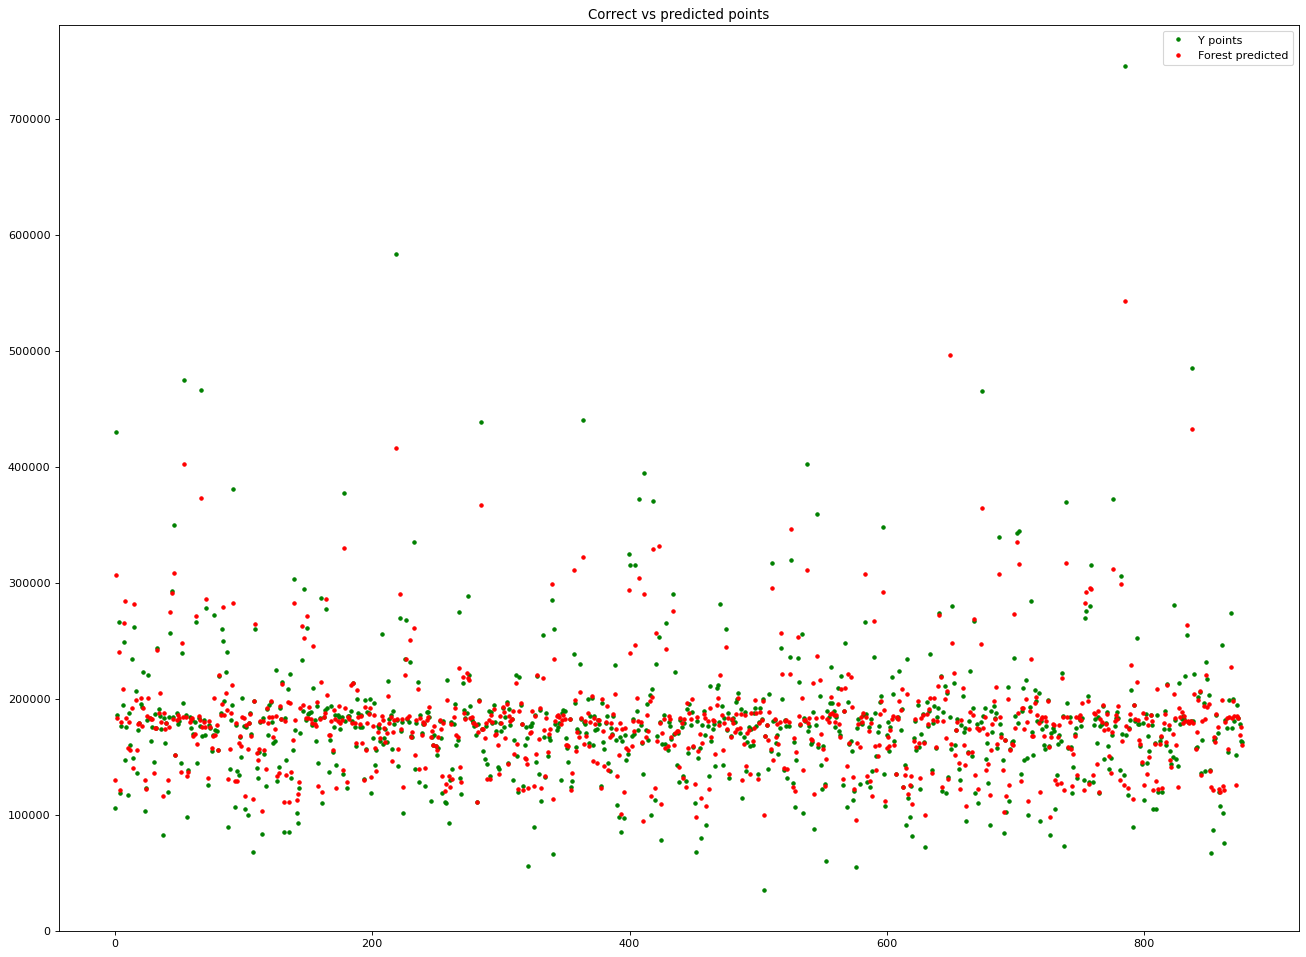

In [19]:
x_points = np.linspace(0, len(test_num_le_y), len(test_num_le_y))

figure(figsize=(20, 15), dpi=80)
plt.title('Correct vs predicted points')
plt.plot(x_points, test_num_le_y, "g.", label='Y points')
#plt.plot(x_points, y_prediction_reg, "b.", label='Regression predicted')
plt.plot(x_points, y_prediction_forest, "r.", label='Forest predicted')
plt.legend()
plt.show()